In [1]:
import sys
sys.path.insert(0, '../src')

/mnt/c/Users/Jacob/Desktop/prosjektoppgave/tcav_atari/src


In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

from concepts import concept_instances
from utils import load_game_data

ModuleNotFoundError: No module named 'matplotlib'

In [4]:
game_data = load_game_data()
concept = concept_instances['ball right paddle (b)']
concept.prepare_data(data)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            # Input is (batch_size, 100, 1, 1)
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # State size: (batch_size, 512, 4, 4)
            
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # State size: (batch_size, 256, 8, 8)
            
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # State size: (batch_size, 128, 16, 16)
            
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # State size: (batch_size, 64, 32, 32)
            
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # State size: (batch_size, 32, 64, 64)

            nn.ConvTranspose2d(32, 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # State size: (batch_size, 16, 128, 128)

            nn.ConvTranspose2d(16, 3, 1, 1, 0, bias=False),  # Adjusted to have 3 output channels
            nn.Tanh()  # Tanh activation function is commonly used for generator's output layer in GANs
        )

    def forward(self, input):
        return self.main(input)  # Scaling to 255 is not necessary if you use Tanh and normalize the images to [-1, 1]

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),  # Adjusted for 3 input channels
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 1),  # Adjusted the linear layer to match the flattened dimensions
            nn.Sigmoid(),
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1)  # this flattens the output tensor

In [7]:
concept.train_images.shape

(3694, 210, 160, 3)

In [8]:
# Convert images to tensors
tensor_train_images = torch.stack([transforms.ToTensor()(img) for img in concept.train_images]).float().to(device)
tensor_test_images = torch.stack([transforms.ToTensor()(img) for img in concept.test_images]).float().to(device)

# Compute mean and std dynamically
mean_train = torch.mean(tensor_train_images, dim=(0, 2, 3))
std_train = torch.std(tensor_train_images, dim=(0, 2, 3))

# Apply normalization dynamically
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert to PIL Image
    transforms.Resize((128, 128)),  # Resize image
    transforms.ToTensor(),  # Convert back to tensor
    #transforms.Normalize(mean_train.tolist(), std_train.tolist())  # Normalize image
])

obs_train_transformed = torch.stack([transform(img) for img in concept.train_images]).float().to(device)
obs_test_transformed = torch.stack([transform(img) for img in concept.test_images]).float().to(device)

# Convert to a dataset
obs_dataset = TensorDataset(obs_train_transformed)

# Create a DataLoader from the dataset
batch_size = 256  # Set your desired batch size
obs_loader = DataLoader(obs_dataset, batch_size=batch_size, shuffle=True)

# Initialize models (assumed that Generator and Discriminator are already defined)
netG = Generator().to(device)
netD = Discriminator().to(device)

# Set up loss and optimizers
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0001, betas=(0.5, 0.999))

In [9]:
mean_train

tensor([0.1707, 0.1497, 0.1252], device='cuda:0')

In [10]:
obs_train_transformed.shape

torch.Size([3694, 3, 128, 128])

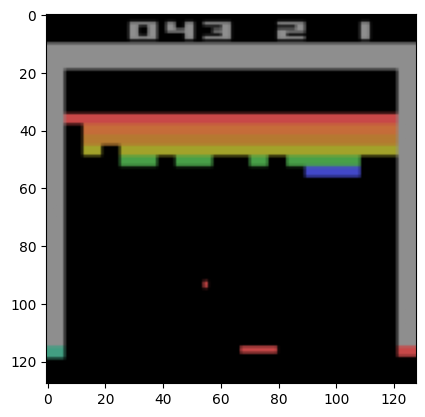

In [11]:
plt.imshow(obs_train_transformed[0].cpu().permute(1, 2, 0))

In [12]:
num_epochs = 500
for epoch in range(num_epochs):
    for i, (data,) in enumerate(obs_loader):
        # Train Discriminator
        netD.zero_grad()
        real_data = data.to(device)
        batch_size = real_data.size(0)
        label = torch.full((batch_size,), 1, dtype=torch.float, device=device)
        output = netD(real_data)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(0)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Train Generator
        netG.zero_grad()
        label.fill_(1)
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Print statistics
        if i % 100 == 0:
            print(f'[{epoch + 1}]\t'
                  f'Loss_D: {errD.item():.4f}\tLoss_G: {errG.item():.4f}\t'
                  f'D(x): {D_x:.4f}\tD(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}')

            if epoch % 10 == 0:
                # Image Reconstruction example
                with torch.no_grad():
                    noise = torch.randn(1, 100, 1, 1, device=device)
                    generated_data = netG(noise).cpu().squeeze().permute(1, 2, 0)
                    plt.imshow(generated_data)
                    plt.savefig(f'../gan/{epoch}.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1]	Loss_D: 1.2118	Loss_G: 1.0477	D(x): 0.6637	D(G(z)): 0.5421/0.3603
[2]	Loss_D: 0.3130	Loss_G: 3.2500	D(x): 0.9569	D(G(z)): 0.2338/0.0402
[3]	Loss_D: 0.1423	Loss_G: 4.0425	D(x): 0.9789	D(G(z)): 0.1135/0.0180
[4]	Loss_D: 0.0877	Loss_G: 4.3392	D(x): 0.9841	D(G(z)): 0.0689/0.0132
[5]	Loss_D: 0.0617	Loss_G: 4.5277	D(x): 0.9873	D(G(z)): 0.0476/0.0110
[6]	Loss_D: 0.0496	Loss_G: 4.5787	D(x): 0.9904	D(G(z)): 0.0391/0.0105
[7]	Loss_D: 0.0383	Loss_G: 4.7353	D(x): 0.9901	D(G(z)): 0.0277/0.0090
[8]	Loss_D: 0.0329	Loss_G: 4.7725	D(x): 0.9924	D(G(z)): 0.0249/0.0087
[9]	Loss_D: 0.0364	Loss_G: 4.7645	D(x): 0.9918	D(G(z)): 0.0277/0.0087
[10]	Loss_D: 0.0224	Loss_G: 5.0357	D(x): 0.9938	D(G(z)): 0.0160/0.0066


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[11]	Loss_D: 0.0196	Loss_G: 5.0409	D(x): 0.9955	D(G(z)): 0.0150/0.0066
[12]	Loss_D: 0.0186	Loss_G: 5.0532	D(x): 0.9961	D(G(z)): 0.0145/0.0065
[13]	Loss_D: 0.0151	Loss_G: 5.1306	D(x): 0.9970	D(G(z)): 0.0120/0.0060
[14]	Loss_D: 0.0147	Loss_G: 5.2409	D(x): 0.9967	D(G(z)): 0.0113/0.0054
[15]	Loss_D: 0.0115	Loss_G: 5.3938	D(x): 0.9971	D(G(z)): 0.0086/0.0046
[16]	Loss_D: 0.0088	Loss_G: 5.6488	D(x): 0.9971	D(G(z)): 0.0059/0.0036
[17]	Loss_D: 0.0090	Loss_G: 5.5947	D(x): 0.9977	D(G(z)): 0.0066/0.0038
[18]	Loss_D: 0.0089	Loss_G: 5.6176	D(x): 0.9974	D(G(z)): 0.0062/0.0037
[19]	Loss_D: 0.0073	Loss_G: 5.8266	D(x): 0.9973	D(G(z)): 0.0046/0.0030
[20]	Loss_D: 0.0064	Loss_G: 6.0459	D(x): 0.9971	D(G(z)): 0.0034/0.0024


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[21]	Loss_D: 0.0062	Loss_G: 5.9927	D(x): 0.9980	D(G(z)): 0.0042/0.0026
[22]	Loss_D: 0.0044	Loss_G: 6.3498	D(x): 0.9980	D(G(z)): 0.0024/0.0018
[23]	Loss_D: 0.0039	Loss_G: 6.3418	D(x): 0.9988	D(G(z)): 0.0027/0.0018
[24]	Loss_D: 0.0039	Loss_G: 6.4356	D(x): 0.9983	D(G(z)): 0.0022/0.0017
[25]	Loss_D: 0.0039	Loss_G: 6.3453	D(x): 0.9988	D(G(z)): 0.0027/0.0018
[26]	Loss_D: 0.0030	Loss_G: 6.6971	D(x): 0.9985	D(G(z)): 0.0015/0.0013
[27]	Loss_D: 0.0033	Loss_G: 6.5310	D(x): 0.9987	D(G(z)): 0.0020/0.0015
[28]	Loss_D: 0.0034	Loss_G: 6.5270	D(x): 0.9991	D(G(z)): 0.0025/0.0015
[29]	Loss_D: 0.0030	Loss_G: 6.7204	D(x): 0.9985	D(G(z)): 0.0015/0.0013
[30]	Loss_D: 0.0024	Loss_G: 6.9022	D(x): 0.9990	D(G(z)): 0.0014/0.0011


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[31]	Loss_D: 0.0026	Loss_G: 6.8238	D(x): 0.9988	D(G(z)): 0.0014/0.0011
[32]	Loss_D: 0.0054	Loss_G: 6.1760	D(x): 0.9994	D(G(z)): 0.0048/0.0021
[33]	Loss_D: 0.0030	Loss_G: 6.8627	D(x): 0.9992	D(G(z)): 0.0022/0.0011
[34]	Loss_D: 0.0023	Loss_G: 6.9319	D(x): 0.9990	D(G(z)): 0.0013/0.0010
[35]	Loss_D: 0.0020	Loss_G: 7.2071	D(x): 0.9986	D(G(z)): 0.0006/0.0008
[36]	Loss_D: 0.0015	Loss_G: 7.2760	D(x): 0.9993	D(G(z)): 0.0008/0.0007
[37]	Loss_D: 0.0020	Loss_G: 7.2094	D(x): 0.9994	D(G(z)): 0.0014/0.0008
[38]	Loss_D: 0.0016	Loss_G: 7.3700	D(x): 0.9995	D(G(z)): 0.0011/0.0007
[39]	Loss_D: 0.0016	Loss_G: 7.3100	D(x): 0.9992	D(G(z)): 0.0008/0.0007
[40]	Loss_D: 0.0016	Loss_G: 7.2697	D(x): 0.9993	D(G(z)): 0.0009/0.0007


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[41]	Loss_D: 0.0010	Loss_G: 7.7157	D(x): 0.9995	D(G(z)): 0.0005/0.0005
[42]	Loss_D: 0.0012	Loss_G: 7.6779	D(x): 0.9996	D(G(z)): 0.0008/0.0005
[43]	Loss_D: 0.0012	Loss_G: 7.6858	D(x): 0.9996	D(G(z)): 0.0008/0.0005
[44]	Loss_D: 0.0010	Loss_G: 7.6908	D(x): 0.9995	D(G(z)): 0.0005/0.0005
[45]	Loss_D: 0.0013	Loss_G: 7.9923	D(x): 0.9991	D(G(z)): 0.0004/0.0004
[46]	Loss_D: 0.0009	Loss_G: 7.9745	D(x): 0.9996	D(G(z)): 0.0005/0.0004
[47]	Loss_D: 0.0009	Loss_G: 7.7830	D(x): 0.9994	D(G(z)): 0.0003/0.0004
[48]	Loss_D: 0.0012	Loss_G: 8.0507	D(x): 0.9996	D(G(z)): 0.0008/0.0003
[49]	Loss_D: 0.3721	Loss_G: 2.5235	D(x): 0.9624	D(G(z)): 0.2836/0.0803
[50]	Loss_D: 0.1333	Loss_G: 3.2759	D(x): 0.9411	D(G(z)): 0.0698/0.0379


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[51]	Loss_D: 0.0737	Loss_G: 3.9411	D(x): 0.9670	D(G(z)): 0.0392/0.0196
[52]	Loss_D: 0.0534	Loss_G: 4.1856	D(x): 0.9746	D(G(z)): 0.0273/0.0154
[53]	Loss_D: 0.0454	Loss_G: 4.7056	D(x): 0.9860	D(G(z)): 0.0307/0.0092
[54]	Loss_D: 0.0365	Loss_G: 4.5371	D(x): 0.9824	D(G(z)): 0.0185/0.0110
[55]	Loss_D: 0.0260	Loss_G: 4.9409	D(x): 0.9867	D(G(z)): 0.0125/0.0074
[56]	Loss_D: 0.0863	Loss_G: 4.3109	D(x): 0.9679	D(G(z)): 0.0522/0.0134
[57]	Loss_D: 0.1076	Loss_G: 3.5815	D(x): 0.9519	D(G(z)): 0.0566/0.0279
[58]	Loss_D: 0.0734	Loss_G: 4.1076	D(x): 0.9682	D(G(z)): 0.0402/0.0167
[59]	Loss_D: 0.0557	Loss_G: 4.1962	D(x): 0.9680	D(G(z)): 0.0228/0.0156
[60]	Loss_D: 0.0426	Loss_G: 4.6969	D(x): 0.9938	D(G(z)): 0.0357/0.0097


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[61]	Loss_D: 0.0360	Loss_G: 4.2633	D(x): 0.9788	D(G(z)): 0.0144/0.0149
[62]	Loss_D: 3.9258	Loss_G: 0.0003	D(x): 0.0210	D(G(z)): 0.0000/0.9997
[63]	Loss_D: 0.2182	Loss_G: 3.2426	D(x): 0.8936	D(G(z)): 0.1001/0.0393
[64]	Loss_D: 0.2195	Loss_G: 7.3811	D(x): 0.9831	D(G(z)): 0.1830/0.0006
[65]	Loss_D: 0.1184	Loss_G: 3.7957	D(x): 0.9425	D(G(z)): 0.0574/0.0229
[66]	Loss_D: 0.0861	Loss_G: 4.6383	D(x): 0.9682	D(G(z)): 0.0523/0.0100
[67]	Loss_D: 0.1114	Loss_G: 3.7060	D(x): 0.9499	D(G(z)): 0.0582/0.0250
[68]	Loss_D: 0.0713	Loss_G: 3.8451	D(x): 0.9564	D(G(z)): 0.0262/0.0220
[69]	Loss_D: 0.0609	Loss_G: 4.1576	D(x): 0.9663	D(G(z)): 0.0263/0.0160
[70]	Loss_D: 0.0346	Loss_G: 5.2897	D(x): 0.9787	D(G(z)): 0.0129/0.0053


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[71]	Loss_D: 0.0281	Loss_G: 4.9853	D(x): 0.9815	D(G(z)): 0.0094/0.0070
[72]	Loss_D: 0.0391	Loss_G: 4.9434	D(x): 0.9899	D(G(z)): 0.0285/0.0073
[73]	Loss_D: 0.2535	Loss_G: 13.2075	D(x): 0.9982	D(G(z)): 0.2216/0.0000
[74]	Loss_D: 0.2970	Loss_G: 2.5017	D(x): 0.7799	D(G(z)): 0.0453/0.0821
[75]	Loss_D: 0.4729	Loss_G: 8.2207	D(x): 0.9943	D(G(z)): 0.3726/0.0003
[76]	Loss_D: 0.2763	Loss_G: 0.4424	D(x): 0.7758	D(G(z)): 0.0205/0.6436
[77]	Loss_D: 0.1653	Loss_G: 3.4247	D(x): 0.9346	D(G(z)): 0.0928/0.0331
[78]	Loss_D: 6.0477	Loss_G: 3.0148	D(x): 0.0026	D(G(z)): 0.0000/0.0499
[79]	Loss_D: 0.0479	Loss_G: 4.6295	D(x): 0.9641	D(G(z)): 0.0112/0.0100
[80]	Loss_D: 0.0521	Loss_G: 4.3250	D(x): 0.9622	D(G(z)): 0.0134/0.0137


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[81]	Loss_D: 0.0478	Loss_G: 3.8005	D(x): 0.9806	D(G(z)): 0.0277/0.0230
[82]	Loss_D: 0.0563	Loss_G: 4.3762	D(x): 0.9657	D(G(z)): 0.0210/0.0130
[83]	Loss_D: 0.0228	Loss_G: 4.7494	D(x): 0.9875	D(G(z)): 0.0100/0.0091
[84]	Loss_D: 0.0709	Loss_G: 4.8413	D(x): 0.9897	D(G(z)): 0.0586/0.0083
[85]	Loss_D: 0.0213	Loss_G: 5.3005	D(x): 0.9835	D(G(z)): 0.0045/0.0052
[86]	Loss_D: 0.0308	Loss_G: 4.7926	D(x): 0.9904	D(G(z)): 0.0209/0.0086
[87]	Loss_D: 0.0288	Loss_G: 4.6833	D(x): 0.9908	D(G(z)): 0.0193/0.0098
[88]	Loss_D: 0.0216	Loss_G: 4.8401	D(x): 0.9843	D(G(z)): 0.0058/0.0082
[89]	Loss_D: 0.0241	Loss_G: 4.9222	D(x): 0.9922	D(G(z)): 0.0160/0.0076
[90]	Loss_D: 0.0333	Loss_G: 5.0950	D(x): 0.9918	D(G(z)): 0.0248/0.0065


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[91]	Loss_D: 0.0084	Loss_G: 5.6154	D(x): 0.9964	D(G(z)): 0.0048/0.0038
[92]	Loss_D: 0.0111	Loss_G: 5.6856	D(x): 0.9927	D(G(z)): 0.0038/0.0036
[93]	Loss_D: 0.0116	Loss_G: 5.9272	D(x): 0.9919	D(G(z)): 0.0034/0.0028
[94]	Loss_D: 0.0097	Loss_G: 5.5631	D(x): 0.9957	D(G(z)): 0.0054/0.0042
[95]	Loss_D: 0.0138	Loss_G: 5.2233	D(x): 0.9971	D(G(z)): 0.0108/0.0059
[96]	Loss_D: 0.0105	Loss_G: 5.8557	D(x): 0.9946	D(G(z)): 0.0051/0.0031
[97]	Loss_D: 0.0098	Loss_G: 6.0516	D(x): 0.9945	D(G(z)): 0.0042/0.0028
[98]	Loss_D: 0.0123	Loss_G: 5.7702	D(x): 0.9947	D(G(z)): 0.0070/0.0035
[99]	Loss_D: 0.0093	Loss_G: 5.6898	D(x): 0.9978	D(G(z)): 0.0071/0.0038
[100]	Loss_D: 0.0067	Loss_G: 5.8141	D(x): 0.9978	D(G(z)): 0.0046/0.0033


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[101]	Loss_D: 0.0103	Loss_G: 5.5305	D(x): 0.9985	D(G(z)): 0.0088/0.0044
[102]	Loss_D: 0.0053	Loss_G: 6.3838	D(x): 0.9973	D(G(z)): 0.0025/0.0019
[103]	Loss_D: 0.0055	Loss_G: 6.0513	D(x): 0.9981	D(G(z)): 0.0036/0.0026
[104]	Loss_D: 0.0058	Loss_G: 5.8967	D(x): 0.9983	D(G(z)): 0.0040/0.0031
[105]	Loss_D: 0.0040	Loss_G: 6.4603	D(x): 0.9982	D(G(z)): 0.0022/0.0017
[106]	Loss_D: 0.0053	Loss_G: 5.9931	D(x): 0.9986	D(G(z)): 0.0040/0.0027
[107]	Loss_D: 0.0063	Loss_G: 5.7466	D(x): 0.9986	D(G(z)): 0.0049/0.0034
[108]	Loss_D: 0.0050	Loss_G: 5.9681	D(x): 0.9989	D(G(z)): 0.0039/0.0029
[109]	Loss_D: 0.0038	Loss_G: 6.2028	D(x): 0.9989	D(G(z)): 0.0027/0.0022
[110]	Loss_D: 0.0054	Loss_G: 5.8391	D(x): 0.9990	D(G(z)): 0.0044/0.0032


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[111]	Loss_D: 0.0025	Loss_G: 6.7232	D(x): 0.9990	D(G(z)): 0.0015/0.0013
[112]	Loss_D: 0.0030	Loss_G: 6.5049	D(x): 0.9990	D(G(z)): 0.0020/0.0016
[113]	Loss_D: 0.0025	Loss_G: 6.7656	D(x): 0.9990	D(G(z)): 0.0015/0.0012
[114]	Loss_D: 0.0031	Loss_G: 6.4388	D(x): 0.9989	D(G(z)): 0.0020/0.0017
[115]	Loss_D: 0.0027	Loss_G: 6.6217	D(x): 0.9991	D(G(z)): 0.0017/0.0015
[116]	Loss_D: 0.0052	Loss_G: 5.8553	D(x): 0.9991	D(G(z)): 0.0043/0.0031
[117]	Loss_D: 0.0019	Loss_G: 7.1948	D(x): 0.9990	D(G(z)): 0.0009/0.0008
[118]	Loss_D: 0.0049	Loss_G: 5.9570	D(x): 0.9990	D(G(z)): 0.0039/0.0028
[119]	Loss_D: 0.0031	Loss_G: 6.3884	D(x): 0.9991	D(G(z)): 0.0022/0.0018
[120]	Loss_D: 0.0031	Loss_G: 6.3486	D(x): 0.9992	D(G(z)): 0.0023/0.0019


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[121]	Loss_D: 0.0039	Loss_G: 6.1554	D(x): 0.9992	D(G(z)): 0.0031/0.0023
[122]	Loss_D: 0.0020	Loss_G: 7.0497	D(x): 0.9991	D(G(z)): 0.0011/0.0009
[123]	Loss_D: 0.0033	Loss_G: 6.3990	D(x): 0.9991	D(G(z)): 0.0024/0.0018
[124]	Loss_D: 0.0028	Loss_G: 6.5216	D(x): 0.9991	D(G(z)): 0.0019/0.0016
[125]	Loss_D: 0.0019	Loss_G: 7.2087	D(x): 0.9990	D(G(z)): 0.0009/0.0008
[126]	Loss_D: 0.0027	Loss_G: 6.6917	D(x): 0.9992	D(G(z)): 0.0020/0.0013
[127]	Loss_D: 0.0020	Loss_G: 6.9628	D(x): 0.9992	D(G(z)): 0.0013/0.0010
[128]	Loss_D: 0.0026	Loss_G: 6.5322	D(x): 0.9994	D(G(z)): 0.0020/0.0016
[129]	Loss_D: 0.0018	Loss_G: 7.3132	D(x): 0.9991	D(G(z)): 0.0008/0.0007
[130]	Loss_D: 0.0016	Loss_G: 7.3872	D(x): 0.9991	D(G(z)): 0.0008/0.0007


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[131]	Loss_D: 0.0027	Loss_G: 6.4069	D(x): 0.9994	D(G(z)): 0.0021/0.0017
[132]	Loss_D: 0.0034	Loss_G: 6.2991	D(x): 0.9992	D(G(z)): 0.0026/0.0019
[133]	Loss_D: 0.0013	Loss_G: 7.6382	D(x): 0.9993	D(G(z)): 0.0006/0.0005
[134]	Loss_D: 0.0009	Loss_G: 8.6657	D(x): 0.9993	D(G(z)): 0.0002/0.0002
[135]	Loss_D: 0.0012	Loss_G: 7.5207	D(x): 0.9995	D(G(z)): 0.0006/0.0006
[136]	Loss_D: 0.0010	Loss_G: 7.6452	D(x): 0.9995	D(G(z)): 0.0006/0.0005
[137]	Loss_D: 0.0008	Loss_G: 8.6696	D(x): 0.9994	D(G(z)): 0.0002/0.0002
[138]	Loss_D: 0.0015	Loss_G: 7.1457	D(x): 0.9995	D(G(z)): 0.0010/0.0008
[139]	Loss_D: 0.0010	Loss_G: 7.6367	D(x): 0.9995	D(G(z)): 0.0006/0.0005
[140]	Loss_D: 0.0007	Loss_G: 8.1536	D(x): 0.9997	D(G(z)): 0.0003/0.0003


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[141]	Loss_D: 0.0016	Loss_G: 6.9053	D(x): 0.9997	D(G(z)): 0.0012/0.0010
[142]	Loss_D: 0.0009	Loss_G: 7.6971	D(x): 0.9996	D(G(z)): 0.0005/0.0005
[143]	Loss_D: 0.0008	Loss_G: 7.8794	D(x): 0.9997	D(G(z)): 0.0004/0.0004
[144]	Loss_D: 0.0010	Loss_G: 7.6119	D(x): 0.9996	D(G(z)): 0.0006/0.0005
[145]	Loss_D: 0.0006	Loss_G: 8.1288	D(x): 0.9997	D(G(z)): 0.0003/0.0003
[146]	Loss_D: 0.0010	Loss_G: 7.4637	D(x): 0.9997	D(G(z)): 0.0007/0.0006
[147]	Loss_D: 0.0012	Loss_G: 7.2403	D(x): 0.9996	D(G(z)): 0.0008/0.0007
[148]	Loss_D: 0.0006	Loss_G: 8.4759	D(x): 0.9997	D(G(z)): 0.0002/0.0002
[149]	Loss_D: 0.0005	Loss_G: 8.8149	D(x): 0.9997	D(G(z)): 0.0002/0.0002
[150]	Loss_D: 0.0007	Loss_G: 8.1649	D(x): 0.9996	D(G(z)): 0.0003/0.0003


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[151]	Loss_D: 0.0009	Loss_G: 7.5724	D(x): 0.9997	D(G(z)): 0.0006/0.0005
[152]	Loss_D: 0.0007	Loss_G: 7.9387	D(x): 0.9997	D(G(z)): 0.0004/0.0004
[153]	Loss_D: 0.0005	Loss_G: 8.7268	D(x): 0.9997	D(G(z)): 0.0002/0.0002
[154]	Loss_D: 0.0006	Loss_G: 7.9583	D(x): 0.9997	D(G(z)): 0.0004/0.0004
[155]	Loss_D: 0.0006	Loss_G: 8.0968	D(x): 0.9998	D(G(z)): 0.0003/0.0003
[156]	Loss_D: 0.0005	Loss_G: 8.5456	D(x): 0.9997	D(G(z)): 0.0002/0.0002
[157]	Loss_D: 0.0005	Loss_G: 8.2989	D(x): 0.9998	D(G(z)): 0.0003/0.0003
[158]	Loss_D: 0.0006	Loss_G: 8.0545	D(x): 0.9997	D(G(z)): 0.0003/0.0003
[159]	Loss_D: 0.0003	Loss_G: 9.4771	D(x): 0.9997	D(G(z)): 0.0001/0.0001
[160]	Loss_D: 0.0011	Loss_G: 7.1562	D(x): 0.9998	D(G(z)): 0.0009/0.0008


In [ ]:
with torch.no_grad():
    noise = torch.randn(1, 100, 1, 1, device=device)
    generated_data = netG(noise).cpu().squeeze().permute(1, 2, 0)